<a href="https://colab.research.google.com/github/LNshuti/eactrade/blob/main/ec_trade_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [179]:
!pip install networkx --quiet
!pip install python-louvain --quiet

In [3]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from community import community_louvain
import seaborn as sns

# Load your data. Load the parquet file
df = pd.read_parquet('processed\country_partner_sitcproduct4digit_year_2021.parquet')
df

,location_id,partner_id,product_id,year,export_value,import_value,sitc_eci,sitc_coi,location_code,partner_code,sitc_product_code
0,0,7,669,2021.0,13476.0,0.0,1.081984,-0.220936,ABW,ARE,0224
1,1,7,669,2021.0,0.0,581022.0,-1.014010,-0.643190,AFG,ARE,0224
2,2,7,669,2021.0,0.0,6251545.0,-1.040071,-1.115572,AGO,ARE,0224
3,8,7,669,2021.0,4966652.0,1096910.0,-0.197862,0.138124,ARG,ARE,0224
4,9,7,669,2021.0,0.0,7555.0,-0.519808,-0.827174,ARM,ARE,0224
...,...,...,...,...,...,...,...,...,...,...,...
4173745,43,239,838,2021.0,0.0,1135435.0,1.327020,0.191976,CHN,VNM,2860
4173746,186,239,838,2021.0,5096915.0,139691.0,0.192385,0.634911,RUS,VNM,2860
4173747,39,157,838,2021.0,0.0,21217960.0,0.578854,1.445207,CAN,NER,2860
4173748,77,157,838,2021.0,0.0,17648098.0,1.336221,0.634767,FRA,NER,2860


In [12]:
df.columns

Index(['location_id', 'partner_id', 'product_id', 'year', 'export_value',
       'import_value', 'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
       'sitc_product_code'],
      dtype='object')

In [6]:
# Calculate total imports for each location
node_sizes = df.groupby(['product_id', 'location_code', 'partner_code'])['import_value'].sum().to_dict()
# Filter nodes to only include those with > 0
node_sizes = {k: v for k, v in node_sizes.items() if v > 200009683}
node_sizes

{(650, 'CAN', 'USA'): 360519456.0,
 (650, 'CHN', 'AUS'): 240005248.0,
 (650, 'CHN', 'NZL'): 235036256.0,
 (650, 'ESP', 'FRA'): 208712832.0,
 (650, 'IDN', 'AUS'): 471425152.0,
 (650, 'ITA', 'FRA'): 1185010816.0,
 (650, 'USA', 'CAN'): 879072640.0,
 (650, 'USA', 'MEX'): 662069056.0,
 (650, 'VNM', 'AUS'): 247231648.0,
 (651, 'SAU', 'SDN'): 228206048.0,
 (652, 'DEU', 'DNK'): 388744896.0,
 (652, 'DEU', 'NLD'): 311584064.0,
 (652, 'HKG', 'CHN'): 395239200.0,
 (652, 'POL', 'DNK'): 319293024.0,
 (652, 'USA', 'CAN'): 569463296.0,
 (653, 'NLD', 'DEU'): 414974688.0,
 (654, 'CHN', 'HKG'): 644150272.0,
 (654, 'GBR', 'IRL'): 348978944.0,
 (654, 'HKG', 'CHN'): 667396672.0,
 (654, 'IRL', 'GBR'): 379682080.0,
 (656, 'ARE', 'BRA'): 202056880.0,
 (656, 'CAN', 'USA'): 572579520.0,
 (656, 'CHL', 'ARG'): 211553600.0,
 (656, 'CHL', 'BRA'): 565657728.0,
 (656, 'CHL', 'PRY'): 720655296.0,
 (656, 'CHN', 'ARG'): 1767583232.0,
 (656, 'CHN', 'AUS'): 1132953856.0,
 (656, 'CHN', 'BRA'): 4232309248.0,
 (656, 'CHN', 'N

In [7]:
# Calculate total imports for each name and partner, and keep top 10
top_10_imports = df.groupby(['product_id', 'partner_code'])['import_value'].sum().nlargest(10).to_dict()
top_10_imports

{(1437, 'ANS'): 1079170349120.0,
 (1437, 'HKG'): 438435184640.0,
 (1286, 'CHN'): 238228836560.0,
 (1307, 'TWN'): 227969114183.0,
 (1437, 'ARE'): 168235401216.0,
 (1307, 'CHN'): 152356858410.0,
 (1273, 'CHN'): 152189554224.0,
 (1314, 'DEU'): 136822572374.0,
 (1307, 'KOR'): 132640651514.0,
 (865, 'SAU'): 118494469624.0}

In [8]:
# Create a directed graph, filtering for top 10
G = nx.from_pandas_edgelist(df[df.apply(lambda row: (row['product_id'], row['partner_code']) in top_10_imports, axis=1)],
                           'product_id', 'partner_code', edge_attr='import_value', create_using=nx.DiGraph())
G.nodes()

NodeView((1273, 'CHN', 1286, 1307, 'KOR', 'TWN', 1314, 'DEU', 865, 'SAU', 1437, 'ARE', 'HKG', 'ANS'))

In [9]:
G.edges()

OutEdgeView([(1273, 'CHN'), (1286, 'CHN'), (1307, 'CHN'), (1307, 'KOR'), (1307, 'TWN'), (1314, 'DEU'), (865, 'SAU'), (1437, 'ARE'), (1437, 'HKG'), (1437, 'ANS')])

In [13]:
def load_data(file_path):
    """
    Load the dataset from a parquet file.

    Args:
    file_path (str): The path to the parquet file.

    Returns:
    pd.DataFrame: The loaded dataframe.
    """
    return pd.read_parquet(file_path)

def format_currency(x, pos):
    """
    Format the value as currency with commas and a dollar sign.

    Args:
    x (float): The value to format.
    pos (int): Position index (required for the formatter but not used here).

    Returns:
    str: The formatted string.
    """
    return f"${x:,.0f}"

def filter_data(df):
    """
    Filter the necessary columns from the dataframe.

    Args:
    df (pd.DataFrame): The input dataframe.

    Returns:
    pd.DataFrame: The filtered dataframe.
    """
    return df[['product_id', 'export_value', 'import_value', 
               'sitc_eci', 'sitc_coi', 'location_code', 'partner_code',
               'sitc_product_code']]

def create_network_graph(df):
    """
    Create a directed network graph from the dataframe.

    Args:
    df (pd.DataFrame): The filtered dataframe.

    Returns:
    nx.DiGraph: The created network graph.
    """
    G = nx.DiGraph()

    for index, row in df.iterrows():
        country = row['name']
        partner_id = row['partner_id']
        import_value = row['import_value']
        exports = row['exports']

        # Add nodes and weighted edges
        G.add_node(country)
        G.add_node(partner_id)
        G.add_edge(country, partner_id, weight=import_value, label='imports')
        G.add_edge(partner_id, country, weight=exports, label='exports')

    return G


def plot_network_graph(G, partition=None):
    """
    Plot the network graph.

    Args:
    G (nx.DiGraph): The network graph to be plotted.
    partition (dict, optional): The partition of the graph for community detection.
    """
    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 12))

    if partition:
        colors = [partition[node] for node in G.nodes()]
        nx.draw_networkx_nodes(G, pos, node_size=7000, node_color=colors, cmap=plt.cm.rainbow)
    else:
        nx.draw_networkx_nodes(G, pos, node_size=7000)

    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')

    edge_labels = {(u, v): f"{d['label']} ({d['weight']})" for u, v, d in G.edges(data=True)}
    nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=20)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

    plt.title("Comprehensive Network Analysis")
    plt.show()

def calculate_network_statistics(G):
    """
    Calculate and return network statistics.

    Args:
    G (nx.DiGraph): The network graph.

    Returns:
    dict: A dictionary containing network statistics.
    """
    stats = {
        'number_of_nodes': G.number_of_nodes(),
        'number_of_edges': G.number_of_edges(),
        'average_clustering': nx.average_clustering(G),
        'average_shortest_path_length': nx.average_shortest_path_length(G) if nx.is_connected(G.to_undirected()) else 'Graph is not connected',
        'density': nx.density(G)
    }
    return stats

def detect_communities(G):
    """
    Detect communities in the network graph using the Louvain method.

    Args:
    G (nx.DiGraph): The network graph.

    Returns:
    dict: A dictionary with nodes as keys and communities as values.
    """
    partition = community_louvain.best_partition(G.to_undirected())
    return partition

def plot_import_heatmap(df):
    """
    Plots a heatmap of import_value.

    Args:
        df (pd.DataFrame): The filtered dataframe.
    """
    import_matrix = df.pivot(index="name", columns="partner_id", values="import_value") # Updated pivot method syntax
    plt.figure(figsize=(14, 10))
    sns.heatmap(import_matrix, annot=True, fmt=".0f", cmap="YlGnBu")
    plt.title("Rwanda's Largest Import Partners")
    plt.xlabel("Partner ID")
    plt.ylabel("Product Name")

    plt.show()

In [14]:
df_filtered = filter_data(df)
df_filtered

,product_id,export_value,import_value,sitc_eci,sitc_coi,location_code,partner_code,sitc_product_code
0,669,13476.0,0.0,1.081984,-0.220936,ABW,ARE,0224
1,669,0.0,581022.0,-1.014010,-0.643190,AFG,ARE,0224
2,669,0.0,6251545.0,-1.040071,-1.115572,AGO,ARE,0224
3,669,4966652.0,1096910.0,-0.197862,0.138124,ARG,ARE,0224
4,669,0.0,7555.0,-0.519808,-0.827174,ARM,ARE,0224
...,...,...,...,...,...,...,...,...
4173745,838,0.0,1135435.0,1.327020,0.191976,CHN,VNM,2860
4173746,838,5096915.0,139691.0,0.192385,0.634911,RUS,VNM,2860
4173747,838,0.0,21217960.0,0.578854,1.445207,CAN,NER,2860
4173748,838,0.0,17648098.0,1.336221,0.634767,FRA,NER,2860


In [15]:
# Filter out rows where both imports and exports are equal to zero
df_filtered = df_filtered[(df_filtered['import_value'] != 0) | (df_filtered['export_value'] != 0)]
df_filtered

,product_id,export_value,import_value,sitc_eci,sitc_coi,location_code,partner_code,sitc_product_code
0,669,13476.0,0.0,1.081984,-0.220936,ABW,ARE,0224
1,669,0.0,581022.0,-1.014010,-0.643190,AFG,ARE,0224
2,669,0.0,6251545.0,-1.040071,-1.115572,AGO,ARE,0224
3,669,4966652.0,1096910.0,-0.197862,0.138124,ARG,ARE,0224
4,669,0.0,7555.0,-0.519808,-0.827174,ARM,ARE,0224
...,...,...,...,...,...,...,...,...
4173745,838,0.0,1135435.0,1.327020,0.191976,CHN,VNM,2860
4173746,838,5096915.0,139691.0,0.192385,0.634911,RUS,VNM,2860
4173747,838,0.0,21217960.0,0.578854,1.445207,CAN,NER,2860
4173748,838,0.0,17648098.0,1.336221,0.634767,FRA,NER,2860


In [17]:
# Filter out rows where (if imports are equal to zero and exports less than 30000
# Or exports equal to zero and imorts less than 30000)
df_filtered = df_filtered[~(((df_filtered['import_value'] == 0) & (df_filtered['export_value'] < 180000000)) |
                           ((df_filtered['export_value'] == 0) & (df_filtered['import_value'] < 180000000)))]

df_filtered

,product_id,export_value,import_value,sitc_eci,sitc_coi,location_code,partner_code,sitc_product_code
3,669,4966652.0,1096910.0,-0.197862,0.138124,ARG,ARE,0224
5,669,27040060.0,142697.0,-0.549442,-0.412212,AUS,ARE,0224
6,669,114754.0,73401.0,1.675471,-0.331413,AUT,ARE,0224
8,669,11454609.0,259730.0,1.183627,1.186762,BEL,ARE,0224
10,669,10307.0,5237282.0,-0.762808,-1.036089,BGD,ARE,0224
...,...,...,...,...,...,...,...,...
4173457,652,43024.0,286415.0,-0.411196,-0.325374,LAO,KHM,0013
4173496,830,1848.0,82564.0,1.404903,0.672085,USA,CHN,2784
4173582,830,82564.0,1848.0,1.327020,0.191976,CHN,USA,2784
4173719,838,139691.0,5096915.0,0.036365,0.823911,VNM,RUS,2860


In [189]:
G = create_network_graph(df_filtered)
G.nodes()

NodeView(('special transactions', 116, 'telecom', 231, 'books & paper', 'food products', 'healthcare goods', 226, 'clothing', 18, 'vehicles & parts', 61, 227, 'plastic', 81, 111, 17, 'construction', 41, 77, 'leather', 247, 114, 64, 188, 24, 110, 162, 246, 'metals', 'cement', 36, 39, 46, 208, 71, 'petroleum', 103, 209, 7, 'aircrafts', 43, 8, 168, 223, 248, 'fertilizers', 104, 191, 216, 197, 15, 102, 228, 152, 186, 121, 74, 190, 97, 224, 23, 153, 83, 177, 178, 192, 179, 68, 73, 49, 142, 180, 122, 14, 183, 239, 128, 131, 38, 59, 249, 90, 93, 134, 167, 147, 159, 130, 45, 21, 107))

In [190]:
# Display the 10 most prominent edges
# G.edges(data=True)

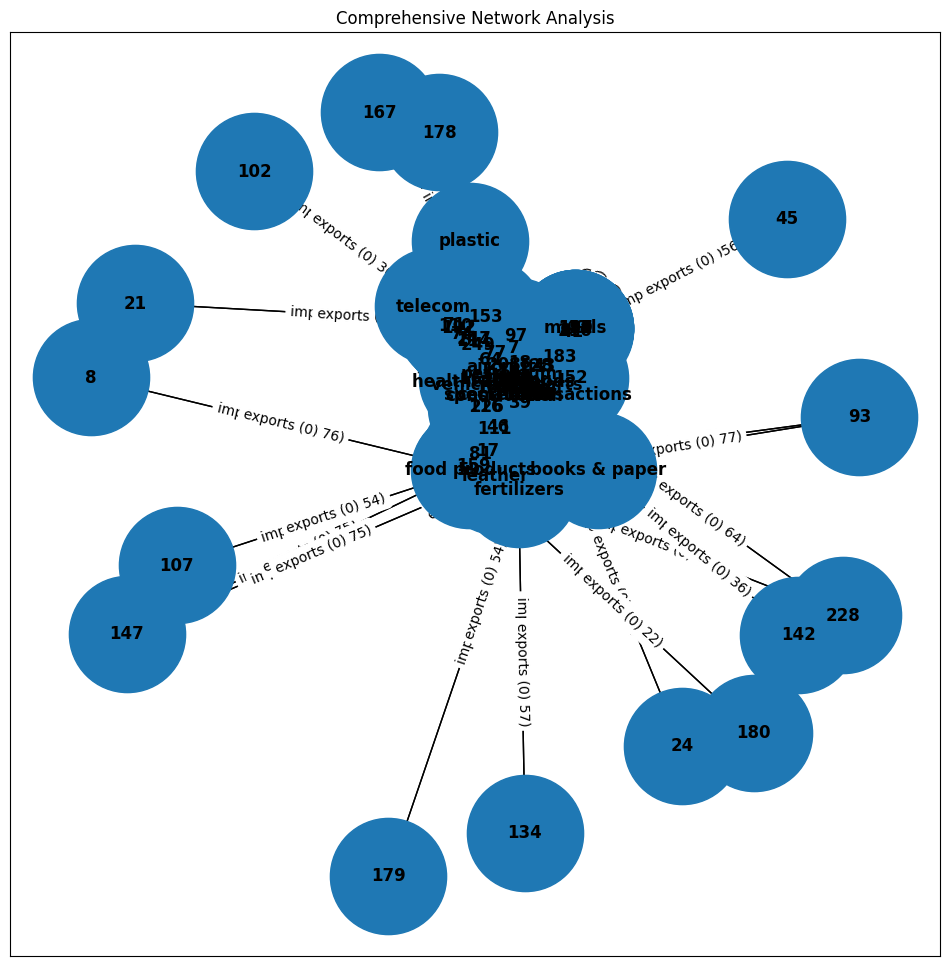

In [191]:
plot_network_graph(G)

In [192]:
partition = detect_communities(G)
#partition

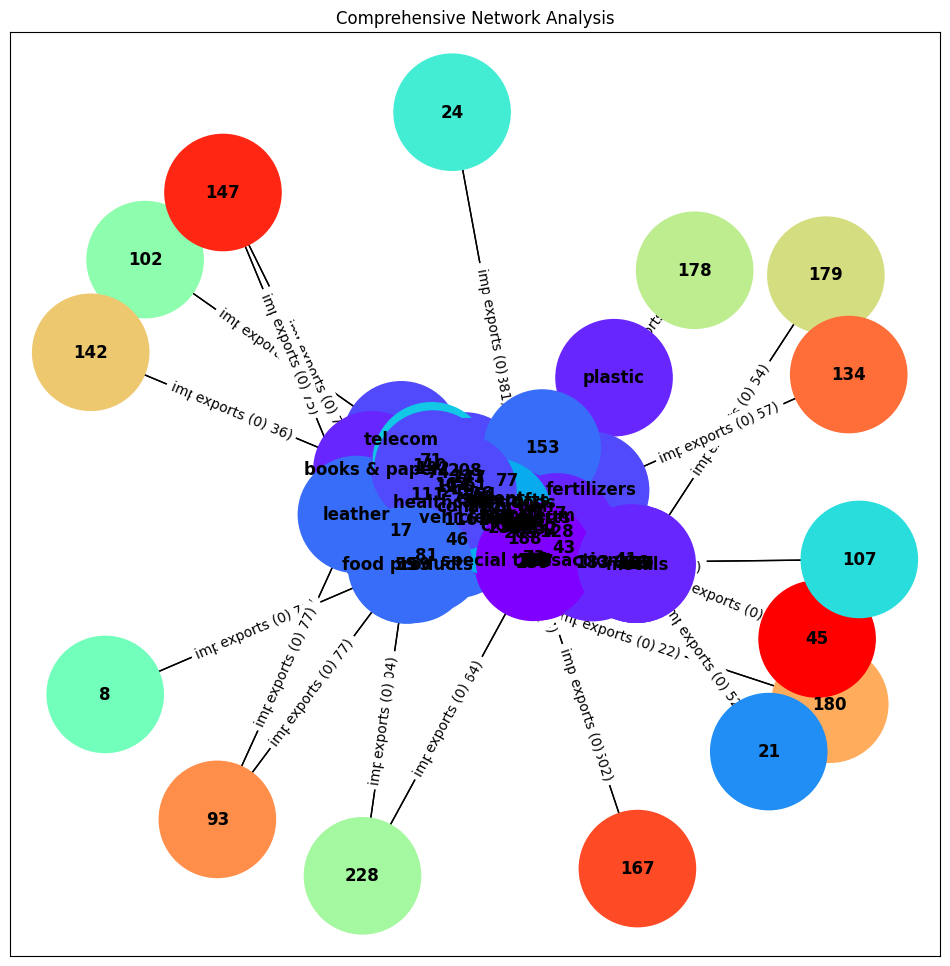

In [193]:
plot_network_graph(G, partition)

3817


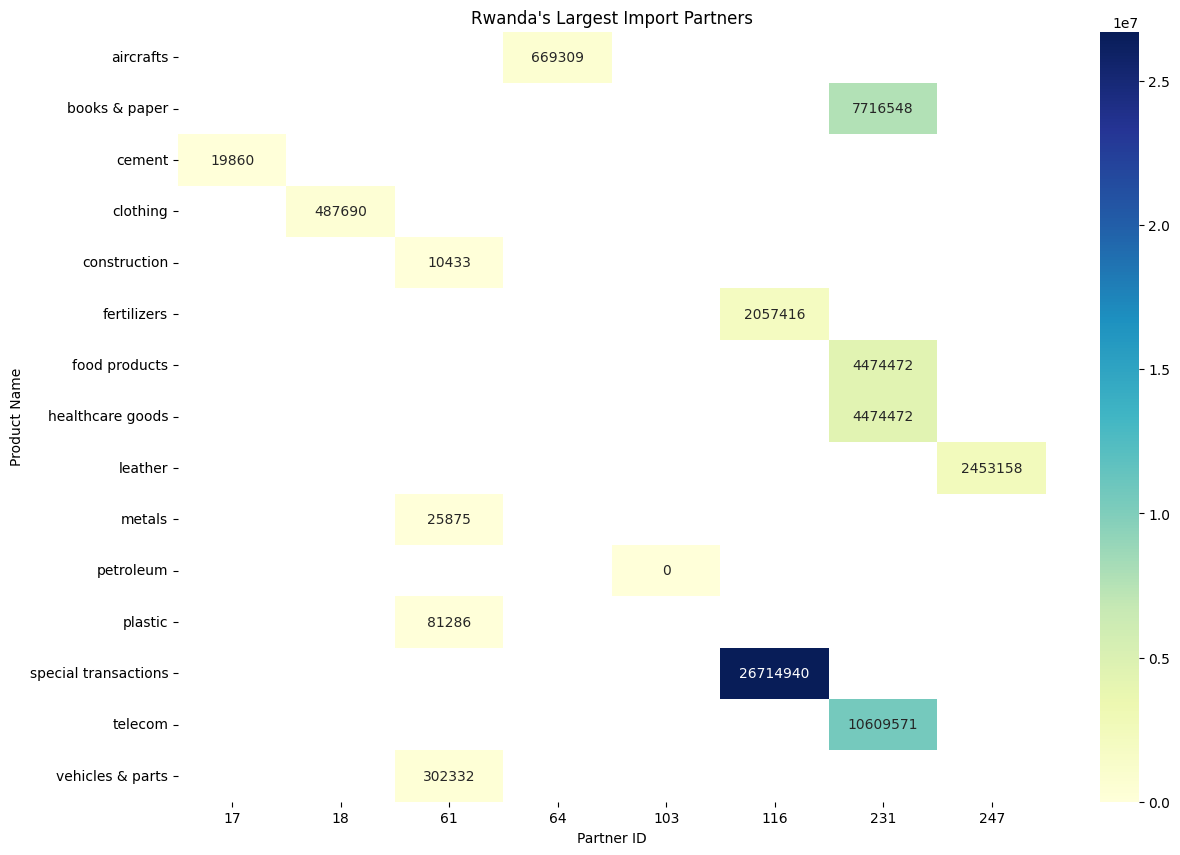

In [194]:
# Check for duplicates in the 'name' column
print(df_filtered['name'].duplicated().sum())

# 1. Drop duplicates:
df_filtered = df_filtered.drop_duplicates(subset=['name'])

# 2. Aggregate duplicates (e.g., sum imports for the same name):
df_filtered = df_filtered.groupby('name').agg({'partner_id': 'first', 'imports': 'sum'}).reset_index()

plot_import_heatmap(df_filtered)

Number of Nodes (92):

This indicates that there are 92 unique entities (countries or partners) in the network. Each node represents either a country or a partner involved in import activities.
Number of Edges (724):

This signifies that there are 724 connections between these nodes. An edge represents an import relationship from one entity to another. For example, if country A imports from country B, there is an edge from B to A.
Average Clustering (0.0):

Clustering coefficient measures the degree to which nodes in a graph tend to cluster together. An average clustering coefficient of 0.0 means that there are no clusters or groups where nodes are interconnected. In this network, it suggests that there are no triads (sets of three nodes) where each node is connected to every other node in the set.

Average Shortest Path Length (2.48):

This metric represents the average number of steps along the shortest paths for all possible pairs of nodes. In this context, it means that, on average, it takes approximately 2.49 steps to travel from one node to another through the shortest path. This indicates a relatively short path length, implying that most nodes are connected through a small number of intermediaries.
Density (0.0865):

Density: ratio of the number of edges to the number of possible edges in the network. A density of approximately 0.086 means that about 8.65% of all possible connections between nodes are actually present in the network. This suggests a relatively sparse network, where most potential connections are not realized.

In [195]:
network_stats = calculate_network_statistics(G)
network_stats

{'number_of_nodes': 92,
 'number_of_edges': 724,
 'average_clustering': 0.0,
 'average_shortest_path_length': 2.4851887243191593,
 'density': 0.0864787386526517}